### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from feature_engine.imputation import CategoricalImputer, DropMissingData
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from feature_engine.wrappers import SklearnTransformerWrapper
from catboost import CatBoostClassifier
import optuna
import warnings

warnings.filterwarnings(action='ignore')

c:\Users\aashi\Desktop\Personal Projects\Data Science\Identifying-Faulty-Water-Pumps-With-Machine-Learning\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')

In [3]:
# merge the two data frames
df = train_values.merge(train_label, on='id')

In [4]:
# check that all rows were in the joined dataset
len(df) == len(train_label) == len(train_values)

True

In [5]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [6]:
# search for duplicates 
df[df['id'].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [7]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['column', 'number of missing values']
missing[missing['number of missing values']>0]

,column,number of missing values
3,funder,3637
5,installer,3655
8,wpt_name,2
11,subvillage,371
18,public_meeting,3334
20,scheme_management,3878
21,scheme_name,28810
22,permit,3056


### Remove Unwanted Fields

In [8]:
# uneeded columns (fields that don't help predict the target label)
unneeded_col = ['id', 'recorded_by', 'wpt_name']
df = df.drop(unneeded_col, axis=1)



### Handling Fields with Too Many Unique Values

In [9]:
# get all categorical variables
df['region_code'] = df['region_code'].astype('object')
df['district_code'] = df['district_code'].astype('object')

cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count_df = pd.DataFrame(col_count.items())
col_count_df.columns = ['Field', 'Number of Unique Values']
col_count_df.head()

,Field,Number of Unique Values
0,date_recorded,356
1,funder,1896
2,installer,2145
3,basin,9
4,subvillage,19287


In [10]:
# redundant data (fields with information provided in other columns)
redundant_col = ['subvillage','latitude', 'longitude', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name', 'extraction_type', 'extraction_type_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'waterpoint_type', 'management']

df = df.drop(redundant_col, axis=1)

### Handle Fields with Missing Values

In [11]:
cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count

{'date_recorded': 356,
 'funder': 1896,
 'installer': 2145,
 'basin': 9,
 'region': 21,
 'public_meeting': 2,
 'scheme_management': 11,
 'permit': 2,
 'extraction_type_class': 7,
 'management_group': 5,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_class': 3,
 'waterpoint_type_group': 6,
 'status_group': 3}

In [12]:
missing = pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index()
missing.columns = ['column', '% missing values']
missing[missing['% missing values']>0]

,column,% missing values
2,funder,6.122896
4,installer,6.153199
9,public_meeting,5.612795
10,scheme_management,6.528620
11,permit,5.144781


### Handle Date Values

In [13]:
# derive age of water pump (i.e., years since construction)
df['construction_year'] = pd.to_datetime(df['construction_year'])
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['age'] = (df['date_recorded'] - df['construction_year']) / np.timedelta64(1, 'Y')

# delete construction_year and date_recorded columns 
df = df.drop(['construction_year', 'date_recorded'], axis=1)

In [14]:
# get quantifiable variables
num_var = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
num_var

['amount_tsh', 'gps_height', 'num_private', 'population', 'age']

### Testing Numerical Features With ANOVA

In [15]:
df.isnull().sum()

amount_tsh                  0
funder                   3637
gps_height                  0
installer                3655
num_private                 0
basin                       0
region                      0
population                  0
public_meeting           3334
scheme_management        3878
permit                   3056
extraction_type_class       0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
status_group                0
age                         0
dtype: int64

<Axes: >

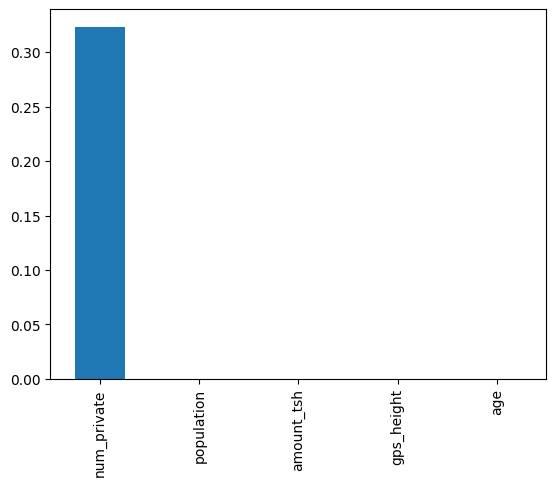

In [16]:
# copy the dataset for ANOVA test
df_int = df.copy(deep=True)

# keep the numerical columns and the target label
int_var = [col for col in df.columns if df[col].dtypes in ['int64', 'float64']] + ['status_group']
df_int = df_int[int_var]

# get the input and output variables
X = df_int.drop('status_group', axis=1)
y = df_int['status_group']

# compute the ANOVA F-statistic for each column
select = SelectKBest(f_classif, k=5)
fit = select.fit(X, y)

# compute the p-values for each F-statistic
p_values = {col: np.round(p_value, 4) for col, p_value in zip(X.columns, fit.pvalues_)}

p_values = pd.Series(p_values.values(),index = p_values.keys())
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [17]:
# columns with high p-values from ANOVA test
anova_drop = ['num_private']
df = df.drop(anova_drop, axis=1)

### Testing Categorical Features With Chi-Square Test

In [18]:
# copy the dataframe for chi square tests
df_chi = df.copy(deep=True)

# keep the categorical variables in the data frame
cat_var = [col for col in df_chi.columns if df[col].dtypes == 'object']
df_chi = df_chi[cat_var]

# encode the categorical variables
label_encoder = LabelEncoder()
for col in df_chi.columns:
    df_chi[col] = label_encoder.fit_transform(df_chi[col])

# get input and output variables
X = df_chi.drop('status_group',axis=1)
y = df_chi['status_group']

# perform chi-square tests
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)


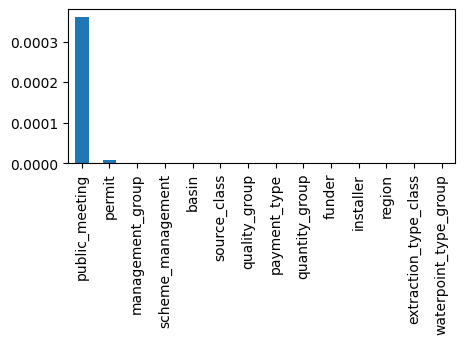

In [19]:
plt.figure(figsize=(5,2))
p_values.plot.bar()
plt.show()


### Baseline Models

In [20]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
X_train.isnull().sum()

amount_tsh                  0
funder                   2548
gps_height                  0
installer                2555
basin                       0
region                      0
population                  0
public_meeting           2297
scheme_management        2733
permit                   2151
extraction_type_class       0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
age                         0
dtype: int64

In [22]:
# encode the target label
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [23]:
# train a dummy classifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

In [24]:
y_train

array([0, 0, 0, ..., 2, 0, 0])

In [25]:
cat_var = [col for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']
num_var = [col for ind, col in enumerate(X_train.columns) if X_train[col].dtypes in ['int64', 'float64']]
num_var
X_train[num_var[0]].min()

0.0

In [26]:
# Define the column transformer
cat_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']
num_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes in ['int64', 'float64']]

# Define column transformer for one-hot encoding categorical features
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('cat_transformer', categorical_transformer, cat_var)
  # replace missing categorical values with mode and one-hot encode
], remainder='passthrough')

# Define final pipeline with preprocessing and logistic regression model
pipeline_log = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('logistic_regression', LogisticRegression())
])

pipeline_log.fit(X_train, y_train)
y_pred_log = pipeline_log.predict(X_test)

In [27]:
f2_score_dummy = fbeta_score(y_test, y_pred_dummy, average='micro', beta=2)
f2_score_log = fbeta_score(y_test, y_pred_log, average='micro', beta=2)

print(f'F2 score of dummy classifier: {f2_score_dummy}')
print(f'F2 score of logistic regression classifier: {f2_score_log}')

F2 score of dummy classifier: 0.32895622895622895
F2 score of logistic regression classifier: 0.6836139169472503


### CatBoost Model

In [147]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Get list of columns with missing values
cols_with_missing = df.columns[df.isna().any()].tolist()


# set up the wrapper with the SimpleImputer
imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                    variables = cols_with_missing)

scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                   variables=num_cols)


pipeline_cbc = Pipeline(steps=[('impute', imputer),
                           ('scaler', scaler),
                           ('rare_label', RareLabelEncoder(replace_with='Unknown', n_categories=10, variables=cat_cols)),
                           ('catboost', CatBoostClassifier(verbose=False, cat_features=cat_indices))
                            ])

pipeline_cbc.fit(X_train, y_train)

Pipeline(steps=[('impute',
                 SklearnTransformerWrapper(transformer=SimpleImputer(strategy='most_frequent'),
                                           variables=['funder', 'installer',
                                                      'public_meeting',
                                                      'scheme_management',
                                                      'permit'])),
                ('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['amount_tsh',
                                                      'gps_height',
                                                      'population', 'age'])),
                ('rare_label',
                 RareLabelEncoder(replace_with='Unknown',
                                  variables=['funder', 'installer', 'basin',
                                             'region', 'public_meeting',
                                             'scheme_management', 'permit',
                                             'extraction_type_class',
                                             'management_group', 'payment_type',
                                             'quality_group', 'quantity_group',
                                             'source_class',
                                             'waterpoint_type_group'])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x000002859680C0A0>)])

In [148]:
y_pred_cbc= pipeline_cbc.predict(X_test)
f2_score_cbc = fbeta_score(y_test, y_pred_cbc, beta=2, average='micro')
f2_score_cbc

0.774635241301908

In [74]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='weighted')

f2_scorer = make_scorer(f2_score)

In [156]:

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10)
    }

    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Get list of columns with missing values
    cols_with_missing = df.columns[df.isna().any()].tolist()


    # set up the wrapper with the SimpleImputer
    imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                        variables = cols_with_missing)

    scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=num_cols)


    pipeline_cbc = Pipeline(steps=[('impute', imputer),
                            ('scaler', scaler),
                            ('rare_label', RareLabelEncoder(replace_with='Unknown', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**params, verbose=False, cat_features=cat_indices, early_stopping_rounds=50))
                                ])

        

    # Perform cross-validation with the pipeline and return the F2 score
    score = cross_val_score(pipeline_cbc, X_train, y_train, cv=3, scoring=f2_scorer).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-05-04 17:17:03,413] A new study created in memory with name: no-name-24d0e7cb-c5bb-49f3-ba56-56830fac5f83
[I 2023-05-04 17:30:03,909] Trial 0 finished with value: 0.7675752982488673 and parameters: {'learning_rate': 0.05603576670294327, 'iterations': 700, 'depth': 10}. Best is trial 0 with value: 0.7675752982488673.
[I 2023-05-04 17:41:08,367] Trial 1 finished with value: 0.7694795276440004 and parameters: {'learning_rate': 0.09866258845879192, 'iterations': 900, 'depth': 9}. Best is trial 1 with value: 0.7694795276440004.
[I 2023-05-04 17:46:00,180] Trial 2 finished with value: 0.7587481531171764 and parameters: {'learning_rate': 0.09836079724985851, 'iterations': 900, 'depth': 6}. Best is trial 1 with value: 0.7694795276440004.
[I 2023-05-04 17:46:18,023] Trial 3 finished with value: 0.7123135206464509 and parameters: {'learning_rate': 0.06580653425916695, 'iterations': 100, 'depth': 5}. Best is trial 1 with value: 0.7694795276440004.
[I 2023-05-04 17:53:25,513] Trial 4 finis

In [157]:
best_params = study.best_params
# perform one hot encoding on the categorical features

pipeline_cbc = Pipeline(steps=[('impute', imputer),
                            ('scaler', scaler),
                            ('rare_label', RareLabelEncoder(replace_with='Unknown', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**best_params, verbose=False, cat_features=cat_indices))
                                ])
    
pipeline_cbc.fit(X_train, y_train)
y_pred_cbc= pipeline_cbc.predict(X_test)

In [158]:
f2_score_cbc = fbeta_score(y_test, y_pred_cbc, beta=2, average='micro')
f2_score_cbc

0.7853535353535354

#### Stratified Split

In [31]:

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10)
    }

    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Get list of columns with missing values
    cols_with_missing = df.columns[df.isna().any()].tolist()


    # set up the wrapper with the SimpleImputer
    imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                        variables = cols_with_missing)

    scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=num_cols)


    pipeline_cbc = Pipeline(steps=[('impute', imputer),
                            ('scaler', scaler),
                            ('rare_label', RareLabelEncoder(replace_with='Unknown', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**params, verbose=False, cat_features=cat_indices, early_stopping_rounds=50))
                                ])
    
    # Define cross-validation method
    sfk = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    y_train_df = pd.Series(y_train)

     # Train and evaluate model using f1_score
    f1_scores = []
    for train_idx, test_idx in sfk.split(X_train, y_train_df):
        X_train_split, X_test_split = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_split, y_test_split = y_train_df.iloc[train_idx], y_train_df.iloc[test_idx]

        pipeline_cbc.fit(X_train_split, y_train_split)
        y_pred = pipeline_cbc.predict(X_test_split)

        f1_scores.append(fbeta_score(y_test_split, y_pred, beta=2, average='micro'))

    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-05-04 22:41:34,405] A new study created in memory with name: no-name-ac7fcdab-883f-49a1-9648-ab103d69a784
[I 2023-05-04 22:45:18,467] Trial 0 finished with value: 0.7333092833092834 and parameters: {'learning_rate': 0.007698271779089503, 'iterations': 1000, 'depth': 5}. Best is trial 0 with value: 0.7333092833092834.
[I 2023-05-04 22:50:37,047] Trial 1 finished with value: 0.7541606541606543 and parameters: {'learning_rate': 0.03168731930265104, 'iterations': 900, 'depth': 6}. Best is trial 1 with value: 0.7541606541606543.
[I 2023-05-04 22:50:55,422] Trial 2 finished with value: 0.7222222222222222 and parameters: {'learning_rate': 0.040024648514626476, 'iterations': 100, 'depth': 5}. Best is trial 1 with value: 0.7541606541606543.
[I 2023-05-04 22:52:28,052] Trial 3 finished with value: 0.7482443482443483 and parameters: {'learning_rate': 0.09421409726735168, 'iterations': 500, 'depth': 4}. Best is trial 1 with value: 0.7541606541606543.
[I 2023-05-04 22:55:45,549] Trial 4 fin

1. lack of understanding of variables (hard to address many unique values)
2. Lack of information on business constraints (cost of repairing/replacing a water pump)